# Task 1

In [223]:
from matplotlib import markers
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import random
import time

In [3]:
partition_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [189]:
def generative(X, Y):
    N = X.shape[0]
    d = X.shape[1]
    N_test = int(N/3)
    N_train = N-N_test
    all_index = [i for i in range(N)]
    generative_result = {}
    for times in range(1, 31):
        test_index = random.sample(all_index, N_test)
        train_index = [x for x in all_index if x not in test_index]
        xtrain = X[train_index,:]
        ytrain = Y[train_index]
        xtest = X[test_index,:]
        ytest = Y[test_index]
        for pv in partition_values:
            alpha = 0.1
            pv_N = int(pv*N_train)
            xpv = xtrain[:pv_N,]
            ypv = ytrain[:pv_N]
            W_old = np.zeros(xpv.shape[1])
            
            #Generative model
            class1 = xpv[(np.where(ypv==1)[0]),:]
            mu1 = np.mean(class1, axis=0)
            class2 = xpv[(np.where(ypv==0)[0]),:]
            mu2 = np.mean(class2, axis=0)
            
            #S1 calculation
            summation = np.zeros((d,d))
            for i in range(class1.shape[0]):
                summation+= np.outer((class1[i,:]-mu1), (class1[i,:]-mu1))
            
            S1 = summation/class1.shape[0]
            
            #S1 calculation
            summation = np.zeros((d,d))
            for i in range(class2.shape[0]):
                summation+= np.outer((class2[i,:]-mu2), (class2[i,:]-mu2))
            
            S2 = summation/class2.shape[0]
            
            S = ((class1.shape[0]/pv_N)*S1) + ((class2.shape[0]/pv_N)*S2)
            #print(S)
            
            W = np.dot(np.linalg.inv(S),(mu1-mu2))
            PC1 = class1.shape[0]/pv_N
            PC2 = class2.shape[0]/pv_N
            
            term1 = -0.5*np.dot(np.dot(mu1, np.linalg.inv(S)),mu1)
            term2 = 0.5*np.dot(np.dot(mu2, np.linalg.inv(S)),mu2)
            term3 = np.log(PC1/PC2)
            
            W0 = term1 + term2 + term3
            #print(W0)
            
            # Prediction
            pred = np.zeros(xtest.shape[0])
            for i in range(pred.size):
                x_test = xtest[i,:]
                pred[i] = np.dot(W,x_test) + W0
            prediction = np.where(pred>=0.5,1,0)
            error = np.sum(np.logical_xor(ytest, prediction))
            test_error = error/ytest.size
            
            generative_result[(str(times),str(pv))] = test_error
    return generative_result

In [209]:
def discriminative(X, Y):
    N = X.shape[0]
    d = X.shape[1]
    N_test = int(N/3)
    N_train = N-N_test
    all_index = [i for i in range(N)]
    discriminative_result = {}
    logisticR_X = np.c_[np.ones(N),X]
    for times in range(1, 31):
        test_index = random.sample(all_index, N_test)
        train_index = [x for x in all_index if x not in test_index]
        xtrain = logisticR_X[train_index,:]
        ytrain = Y[train_index]
        xtest = logisticR_X[test_index,:]
        ytest = Y[test_index]
        for pv in partition_values:
            alpha = 0.1
            pv_N = int(pv*N_train)
            xpv = xtrain[:pv_N,]
            ypv = ytrain[:pv_N]
            W_old = np.zeros(xpv.shape[1])
            #W_new = np.matrix(np.zeros(xpv.shape[1]))
            iteration = 0
            while True:
                a = np.dot(xpv, W_old)
                y = 1/(1 + np.exp(-a))
                R = np.diag(y*(1-y))
                term_1 = alpha*np.identity(d+1) + np.dot(np.dot(xpv.T,R),xpv)
                term_2 = np.dot(xpv.T, (y-ypv)) + alpha*W_old
                W_new = W_old - np.dot(np.linalg.inv(term_1),term_2)

                #W_old=W_new
                iteration+=1
                if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>100:
                    break
                else:
                    W_old = W_new

            # SN calculation
            a = np.dot(xpv, W_new)
            y = 1/(1 + np.exp(-a))
            summation = np.zeros((d+1,d+1))
            for i in range(y.size):
                summation+= (y[i]*(1-y[i]))*np.dot(xpv[i,:], xpv[i,:])
            
            SN = alpha*np.identity(d+1) + summation
            
            #predictions

            pred = np.zeros(xtest.shape[0])
            for i in range(pred.size):
                phi = xtest[i,:]
                mu = np.dot(W_new.T, phi)
                sigma_sq = np.dot(np.dot(phi.T, SN), phi)
                a = 1/np.sqrt(1 + (np.pi*sigma_sq/8))

                pred[i] = 1/(1 + np.exp(-(a*mu)))
            
            prediction = np.where(pred>=0.5,1,0)
            error = np.sum(np.logical_xor(ytest, prediction))
            test_error = error/ytest.size
            
            
            discriminative_result[(str(times),str(pv))] = test_error
    return discriminative_result

In [210]:
def average_error(gr, dr):

    generative_avg = {}
    discriminative_avg = {}

    for pv in partition_values:
        arr = np.array([gr[(str(e),str(pv))] for e in range(1,31)])
        arr1 = np.array([dr[(str(e),str(pv))] for e in range(1,31)])
        generative_avg[(str(pv), "Generative")] = (np.mean(arr), np.std(arr))
        discriminative_avg[(str(pv), "Discriminative")] = (np.mean(arr1), np.std(arr1))
    return generative_avg, discriminative_avg

In [211]:
# dataset - A

In [212]:
data = pd.read_csv(r'pp3data/A.csv', header=None)
labels = pd.read_csv(r'pp3data/labels-A.csv', header=None)

X = data.to_numpy()
Y = labels.to_numpy().flatten()

generative_result = generative(X,Y)
discriminative_result = discriminative(X, Y)

generative_result, discriminative_result = average_error(generative_result, discriminative_result)

<ipython-input-209-5af78dea5294>:34: RuntimeWarning: divide by zero encountered in double_scalars
  if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>100:


In [213]:
generative_result, discriminative_result

({('0.1', 'Generative'): (0.165015015015015, 0.023921672612816372),
  ('0.2', 'Generative'): (0.11716716716716716, 0.014709010627240397),
  ('0.3', 'Generative'): (0.09109109109109109, 0.013559776961105172),
  ('0.4', 'Generative'): (0.07827827827827825, 0.011808418100547448),
  ('0.5', 'Generative'): (0.07547547547547546, 0.012222464066918189),
  ('0.6', 'Generative'): (0.06661661661661661, 0.010420631965074504),
  ('0.7', 'Generative'): (0.06366366366366366, 0.01068495307787219),
  ('0.8', 'Generative'): (0.06181181181181182, 0.008432356620287431),
  ('0.9', 'Generative'): (0.06001001001001002, 0.008954484093904605),
  ('1', 'Generative'): (0.057007007007007005, 0.009104295332358465)},
 {('0.1', 'Discriminative'): (0.3586586586586586, 0.02501921854558945),
  ('0.2', 'Discriminative'): (0.1853853853853854, 0.023869414071302348),
  ('0.3', 'Discriminative'): (0.11636636636636635, 0.01899958176461665),
  ('0.4', 'Discriminative'): (0.09214214214214213, 0.015514627505344516),
  ('0.5', '

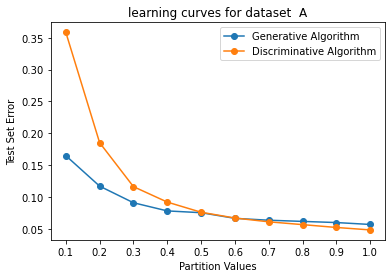

In [214]:
plt.figure(1)
plt.plot(partition_values, [generative_result[(str(pv), 'Generative')][0] for pv in partition_values], marker = 'o', label = 'Generative Algorithm')
plt.plot(partition_values, [discriminative_result[(str(pv), 'Discriminative')][0] for pv in partition_values], marker = 'o', label = 'Discriminative Algorithm')
plt.xlabel('Partition Values')
plt.ylabel('Test Set Error')
plt.title('learning curves for dataset  A')
plt.legend()
plt.xticks(partition_values)
plt.show()

In [215]:
# dataset - B

In [216]:
data = pd.read_csv(r'pp3data/B.csv', header=None)
labels = pd.read_csv(r'pp3data/labels-B.csv', header=None)

X = data.to_numpy()
Y = labels.to_numpy().flatten()

generative_result = generative(X,Y)
discriminative_result = discriminative(X, Y)

generative_result, discriminative_result = average_error(generative_result, discriminative_result)

<ipython-input-209-5af78dea5294>:34: RuntimeWarning: divide by zero encountered in double_scalars
  if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>100:


In [217]:
generative_result, discriminative_result

({('0.1', 'Generative'): (0.34242424242424246, 0.06278897077947497),
  ('0.2', 'Generative'): (0.27878787878787886, 0.05623097236249204),
  ('0.3', 'Generative'): (0.2803030303030302, 0.050517675189788384),
  ('0.4', 'Generative'): (0.23939393939393938, 0.05834153162906527),
  ('0.5', 'Generative'): (0.21767676767676766, 0.048624063603006876),
  ('0.6', 'Generative'): (0.2151515151515152, 0.04535342286998717),
  ('0.7', 'Generative'): (0.20656565656565656, 0.04130621561735825),
  ('0.8', 'Generative'): (0.1944444444444444, 0.03933237873219705),
  ('0.9', 'Generative'): (0.17525252525252527, 0.04297680080708041),
  ('1', 'Generative'): (0.17626262626262623, 0.040746653437434256)},
 {('0.1', 'Discriminative'): (0.21363636363636365, 0.05045704789499004),
  ('0.2', 'Discriminative'): (0.2095959595959596, 0.052206198819528746),
  ('0.3', 'Discriminative'): (0.2292929292929293, 0.05096757903653683),
  ('0.4', 'Discriminative'): (0.2095959595959596, 0.053509141667719924),
  ('0.5', 'Discrimin

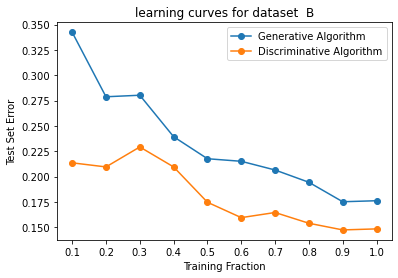

In [218]:
plt.figure(2)
plt.plot(partition_values, [generative_result[(str(pv), 'Generative')][0] for pv in partition_values], marker = 'o', label = 'Generative Algorithm')
plt.plot(partition_values, [discriminative_result[(str(pv), 'Discriminative')][0] for pv in partition_values], marker = 'o', label = 'Discriminative Algorithm')
plt.xlabel('Training Fraction')
plt.ylabel('Test Set Error')
plt.title('learning curves for dataset  B')
plt.legend()
plt.xticks(partition_values)
plt.show()

In [219]:
# dataset USPS

In [220]:
data = pd.read_csv(r'pp3data/usps.csv', header=None)
labels = pd.read_csv(r'pp3data/labels-usps.csv', header=None)

X = data.to_numpy()
Y = labels.to_numpy().flatten()

generative_result = generative(X,Y)
discriminative_result = discriminative(X, Y)

generative_result, discriminative_result = average_error(generative_result, discriminative_result)

<ipython-input-209-5af78dea5294>:34: RuntimeWarning: divide by zero encountered in double_scalars
  if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>100:


In [221]:
generative_result, discriminative_result

({('0.1', 'Generative'): (0.49831059129304733, 0.0363866262823458),
  ('0.2', 'Generative'): (0.4994152046783626, 0.03380965978540354),
  ('0.3', 'Generative'): (0.20311890838206625, 0.028232151251823268),
  ('0.4', 'Generative'): (0.11150097465886938, 0.017861537916499505),
  ('0.5', 'Generative'): (0.08382066276803118, 0.00938915756630978),
  ('0.6', 'Generative'): (0.07166991552956464, 0.010298639163955996),
  ('0.7', 'Generative'): (0.06179337231968811, 0.010030308455587585),
  ('0.8', 'Generative'): (0.05464587394411956, 0.007541002011396943),
  ('0.9', 'Generative'): (0.05081221572449642, 0.0069546917012395845),
  ('1', 'Generative'): (0.050227420402859, 0.0059271939867348725)},
 {('0.1', 'Discriminative'): (0.06361273554256011, 0.00818532938009244),
  ('0.2', 'Discriminative'): (0.057374918778427535, 0.008110713185265465),
  ('0.3', 'Discriminative'): (0.05724496426250812, 0.0072498431985036915),
  ('0.4', 'Discriminative'): (0.05445094217024042, 0.0067888020203295514),
  ('0.5'

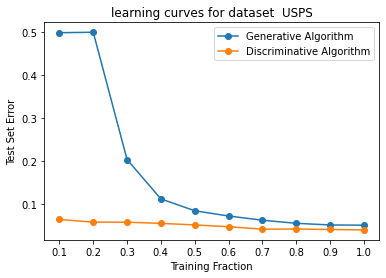

In [222]:
plt.figure(3)
plt.plot(partition_values, [generative_result[(str(pv), 'Generative')][0] for pv in partition_values], marker = 'o', label = 'Generative Algorithm')
plt.plot(partition_values, [discriminative_result[(str(pv), 'Discriminative')][0] for pv in partition_values], marker = 'o', label = 'Discriminative Algorithm')
plt.xlabel('Training Fraction')
plt.ylabel('Test Set Error')
plt.title('learning curves for dataset  USPS')
plt.legend()
plt.xticks(partition_values)
plt.show()

# Task 2

In [224]:
data = pd.read_csv(r'pp3data/A.csv', header=None)
labels = pd.read_csv(r'pp3data/labels-A.csv', header=None)

X = data.to_numpy()
N = X.shape[0]
Y = labels.to_numpy().flatten()
newX = np.c_[np.ones(N),X]

train_size = int((2/3) * len(data))
xtrain = newX[:train_size]
ytrain = Y[:train_size]
xtest = newX[train_size:]
ytest = Y[train_size:]


In [225]:
def newton(newX,Y):
    N = newX.shape[0]
    d = newX.shape[1]
    train_size = int((2/3) * len(data))
    xtrain = newX[:train_size]
    ytrain = Y[:train_size]
    xtest = newX[train_size:]
    ytest = Y[train_size:]
   # W_old = np.ones(xtrain.shape[1])
    W_old = np.zeros(xtrain.shape[1])
    alpha = 0.1
    iteration = 0
    weight_vector = {}
    errors = {}
    time_diff = []
    initial_time = time.time()
    while True:
        a = np.dot(xtrain, W_old)
        y = 1/(1 + np.exp(-a))
        #print(y.shape)
        R = np.diag(y*(1-y))
        #print(R.shape,R)
        term_1 = alpha*np.identity(d) + np.dot(np.dot(xtrain.T,R),xtrain)
        term_2 = np.dot(xtrain.T, (y-ytrain)) + alpha*W_old
        W_new = W_old - np.dot(np.linalg.inv(term_1),term_2)
        iteration+=1
        #W_old = W_new
        ts = time.time()
        weight_vector[ts] = W_old 
        
        if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>100:
            break
        else:
            W_old = W_new
    for ts in weight_vector:
                
                
        # SN calculation
        a = np.dot(xtrain, weight_vector[ts])
        y = 1/(1 + np.exp(-a))
        summation = np.zeros((d,d))
        for i in range(y.size):
            summation+= (y[i]*(1-y[i]))*np.dot(xtrain[i,:], xtrain[i,:])
            
        SN = alpha*np.identity(d) + summation
        #predictions

        pred = np.zeros(xtest.shape[0])
        for i in range(pred.size):
            phi = xtest[i,:]
            mu = np.dot(weight_vector[ts].T, phi)
            sigma_sq = np.dot(np.dot(phi.T, SN), phi)
            a = 1/np.sqrt(1 + (np.pi*sigma_sq/8))
            pred[i] = 1/(1 + np.exp(-(a*mu)))
                     
        prediction = np.where(pred>=0.5,1,0)
        error = np.sum(np.logical_xor(ytest, prediction))
        test_error = error/ytest.size
        errors[ts-initial_time] = test_error
        time_diff.append(ts-initial_time)   
            
    return errors, weight_vector, time_diff

In [226]:
def gradient_descent(newX,Y):
    N = newX.shape[0]
    d = newX.shape[1]
    train_size = int((2/3) * len(data))
    xtrain = newX[:train_size]
    ytrain = Y[:train_size]
    xtest = newX[train_size:]
    ytest = Y[train_size:]
    W_old = np.zeros(xtrain.shape[1])
    alpha = 0.1
    iteration = 0
    weight_vector = {}
    errors = {}
    time_diff = []
    initial_time = time.time()
    while True:
        a = np.dot(xtrain, W_old)
        y = 1/(1 + np.exp(-a))
        term_1 = np.dot(xtrain.T, (y-ytrain)) + alpha*W_old
        W_new = W_old - 0.001*(term_1)
        if(iteration%10 == 0):
            ts = time.time()
            weight_vector[ts] = W_old 
        iteration+=1
        if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>6000:
            break
        else:
            W_old = W_new
    for ts in weight_vector:
        
        
    
        # SN calculation
        a = np.dot(xtrain, weight_vector[ts])
        y = 1/(1 + np.exp(-a))
        summation = np.zeros((d,d))
        for i in range(y.size):
            summation+= (y[i]*(1-y[i]))*np.dot(xtrain[i,:], xtrain[i,:])
            
        SN = alpha*np.identity(d) + summation
        #predictions

        pred = np.zeros(xtest.shape[0])
        for i in range(pred.size):
            phi = xtest[i,:]
            mu = np.dot(weight_vector[ts].T, phi)
            sigma_sq = np.dot(np.dot(phi.T, SN), phi)
            a = 1/np.sqrt(1 + (np.pi*sigma_sq/8))
            pred[i] = 1/(1 + np.exp(-(a*mu)))
                     
        prediction = np.where(pred>=0.5,1,0)
        error = np.sum(np.logical_xor(ytest, prediction))
        test_error = error/ytest.size
        
        errors[ts-initial_time] = test_error     
        time_diff.append(ts-initial_time)   
    return errors, weight_vector, time_diff

In [227]:
errors_newton_A1,weight_vector_newton_A1,t1N = newton(newX,Y)
errors_newton_A2,weight_vector_newton_A2,t2N = newton(newX,Y)
errors_newton_A3,weight_vector_newton_A3,t3N = newton(newX,Y)

<ipython-input-225-eefcc4822ef9>:31: RuntimeWarning: divide by zero encountered in double_scalars
  if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>100:


In [228]:
errors_gd_A1,weight_vector_gd_A1, t1G = gradient_descent(newX,Y)
errors_gd_A2,weight_vector_gd_A2, t2G = gradient_descent(newX,Y)
errors_gd_A3,weight_vector_gd_A3, t3G = gradient_descent(newX,Y)

<ipython-input-226-765655dfb483>:25: RuntimeWarning: divide by zero encountered in double_scalars
  if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>6000:


In [229]:
N_A = []
for i in range(len(t1N)):
    N_A.append((t1N[i]+t2N[i]+t3N[i])/3)

In [230]:
N_A

[0.0063169002532958984,
 0.013271570205688477,
 0.01843126614888509,
 0.023821671803792317,
 0.02881034215291341]

In [231]:
GD_A = []
for i in range(len(t1G)):
    GD_A.append((t1G[i]+t2G[i]+t3G[i])/3)

In [232]:
GD_A

[0.00037487347920735675,
 0.0024177233378092446,
 0.004139343897501628,
 0.005756298700968425,
 0.007427295049031575,
 0.009071032206217447,
 0.01071635882059733,
 0.012307087580362955,
 0.01387333869934082,
 0.015648921330769856,
 0.017285664876302082,
 0.01884778340657552,
 0.02041323979695638,
 0.022013028462727863,
 0.023665746053059895,
 0.025325298309326172,
 0.02692699432373047,
 0.028547366460164387,
 0.030089378356933594,
 0.031713008880615234,
 0.033287366231282554,
 0.0348663330078125,
 0.036437273025512695,
 0.03797626495361328,
 0.039551337560017906,
 0.04135489463806152,
 0.042891740798950195,
 0.04435396194458008,
 0.045882781346639,
 0.047322352727254234,
 0.04883003234863281,
 0.05028001467386881,
 0.051723321278889976,
 0.053117990493774414,
 0.05457631746927897,
 0.056093295415242515,
 0.05757570266723633,
 0.058988730112711586,
 0.060415426890055336,
 0.06187295913696289,
 0.06339263916015625,
 0.06487902005513509,
 0.06631135940551758,
 0.06766335169474284,
 0.0691

Text(0.5, 0, 'time')

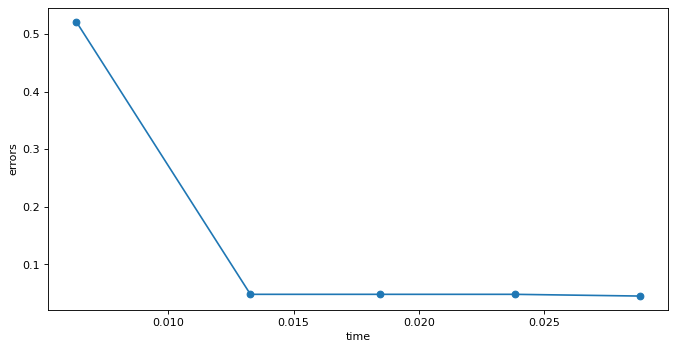

In [234]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot(N_A,errors_newton_A1.values(), marker = 'o', label = "Newton's method")
plt.ylabel('errors')
plt.xlabel('time')

Text(0.5, 0, 'time')

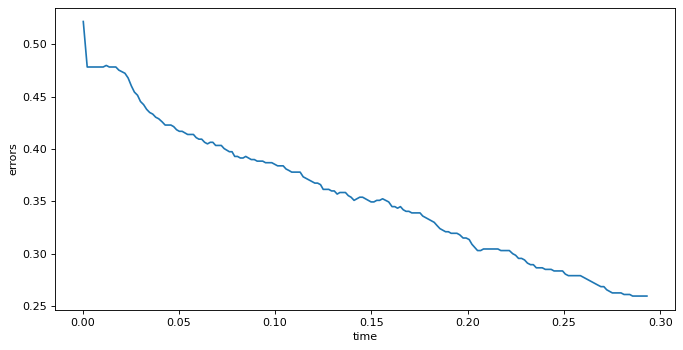

In [235]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot(GD_A,errors_gd_A1.values(), label = "Gradient Descent method")
plt.ylabel('errors')
plt.xlabel('time')

In [236]:
data = pd.read_csv(r'pp3data/usps.csv', header=None)
labels = pd.read_csv(r'pp3data/labels-usps.csv', header=None)

X = data.to_numpy()
N = X.shape[0]
Y = labels.to_numpy().flatten()
newX = np.c_[np.ones(N),X]

train_size = int((2/3) * len(data))
xtrain = newX[:train_size]
ytrain = Y[:train_size]
xtest = newX[train_size:]
ytest = Y[train_size:]


In [271]:
errors_newton_U1,weight_vector_newton_U1,t1N = newton(newX,Y)
errors_newton_U2,weight_vector_newton_U2,t2N = newton(newX,Y)
errors_newton_U3,weight_vector_newton_U3,t3N = newton(newX,Y)

<ipython-input-225-eefcc4822ef9>:31: RuntimeWarning: divide by zero encountered in double_scalars
  if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>100:


In [272]:
errors_gd_U1,weight_vector_gd_U1, t1G = gradient_descent(newX,Y)
errors_gd_U2,weight_vector_gd_U2, t2G = gradient_descent(newX,Y)
errors_gd_U3,weight_vector_gd_U3, t3G = gradient_descent(newX,Y)

<ipython-input-226-765655dfb483>:25: RuntimeWarning: divide by zero encountered in double_scalars
  if ((np.linalg.norm(W_new-W_old)**2)/(np.linalg.norm(W_old)**2)<0.001) or iteration>6000:


In [273]:
N_U = []
for i in range(len(t1N)):
    N_U.append((t1N[i]+t2N[i]+t3N[i])/3)

In [274]:
N_U

[0.007961273193359375,
 0.016689062118530273,
 0.024754683176676433,
 0.03290534019470215,
 0.04019904136657715,
 0.047802368799845375,
 0.05544137954711914,
 0.06278530756632487,
 0.06983304023742676]

In [275]:
GD_U = []
for i in range(len(t1G)):
    GD_U.append((t1G[i]+t2G[i]+t3G[i])/3)

In [276]:
GD_U

[0.0008815924326578776]

Text(0.5, 0, 'time')

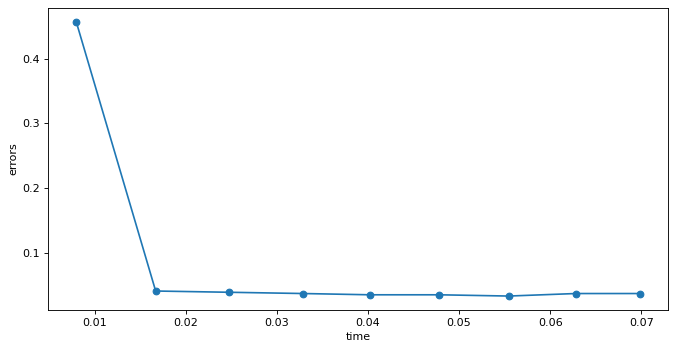

In [277]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot(N_U,errors_newton_U1.values(), marker = 'o', label = "Newton's method")
plt.ylabel('errors')
plt.xlabel('time')

Text(0.5, 0, 'time')

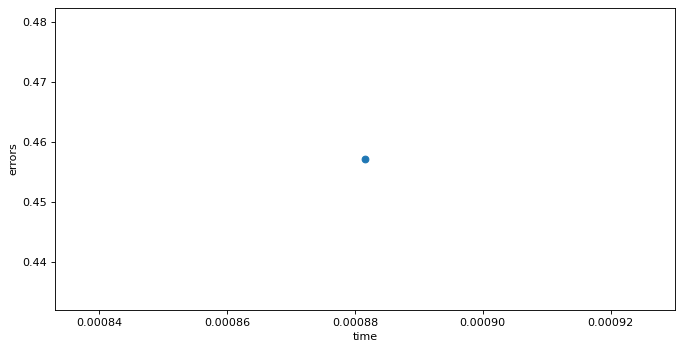

In [278]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot(GD_U,errors_gd_U1.values(), marker = 'o', label = "Gradient Descent method")
plt.ylabel('errors')
plt.xlabel('time')